In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

## Data loading


In [3]:
# Load daily consumption (telelectura)
df_consum = pd.read_parquet("data/consum_telelectura_anonymized.parquet")
df_consum.head()

,POLIZA_SUMINISTRO,FECHA,CONSUMO_REAL,SECCIO_CENSAL,US_AIGUA_GEST,NUM_MUN_SGAB,NUM_DTE_MUNI,NUM_COMPLET,DATA_INST_COMP,MARCA_COMP,CODI_MODEL,DIAM_COMP
0,VECWAVDUULZDSBOP,2021-01-01,1758,801903025.0,C,0.0,3.0,N5ER4KUNPNXOQQCE,2016-04-25,5557SZ47QZAZ56EQ,23.0,30.0
1,VECWAVDUULZDSBOP,2021-01-02,1854,801903025.0,C,0.0,3.0,N5ER4KUNPNXOQQCE,2016-04-25,5557SZ47QZAZ56EQ,23.0,30.0
2,VECWAVDUULZDSBOP,2021-01-03,1885,801903025.0,C,0.0,3.0,N5ER4KUNPNXOQQCE,2016-04-25,5557SZ47QZAZ56EQ,23.0,30.0
3,VECWAVDUULZDSBOP,2021-01-04,5676,801903025.0,C,0.0,3.0,N5ER4KUNPNXOQQCE,2016-04-25,5557SZ47QZAZ56EQ,23.0,30.0
4,VECWAVDUULZDSBOP,2021-01-05,4456,801903025.0,C,0.0,3.0,N5ER4KUNPNXOQQCE,2016-04-25,5557SZ47QZAZ56EQ,23.0,30.0


In [4]:
# Load leak incidents and client communications
df_fuites = pd.read_parquet("data/consum_avisos_missatges_anonymized.parquet")
df_fuites.head()

,POLISSA_SUBM,DATA_INI_FACT,DATA_FIN_FACT,CREATED_MENSAJE,CODIGO_MENSAJE,TIPO_MENSAJE,US_AIGUA_SUBM,SECCIO_CENSAL,NUMEROSERIECONTADOR,CONSUMO_REAL,FECHA_HORA
0,RGYFWIZ4ZRRZKX2K,2023-09-13 00:00:00,2023-11-14 00:00:00,NaT,None,None,DOMÈSTIC,0801907090,IBAJ44VHSIRRTASA,NaN,2024-01-01
1,HHB4U5HUQKW7IOGD,2023-08-13 00:00:00,2023-10-16 00:00:00,NaT,None,None,DOMÈSTIC,0801909040,L2CLPPJRIPAEESV7,NaN,2024-01-01
2,EU6AT3IKPUKCZTBU,2024-01-24 00:00:00,2024-03-26 00:00:00,NaT,None,None,DOMÈSTIC,0801902046,45TBDJQN4LA37ZIN,NaN,2024-01-01
3,EU6AT3IKPUKCZTBU,2023-11-27 00:00:00,2024-01-24 00:00:00,NaT,None,None,DOMÈSTIC,0801902046,45TBDJQN4LA37ZIN,NaN,2024-01-01
4,EWNDTPECBVEGW6AU,2023-09-29 00:00:00,2023-11-27 00:00:00,NaT,None,None,DOMÈSTIC,0801902046,VTRAI3L24SWKVC5H,NaN,2024-01-01


In [ ]:
# Dataset renda mitjana per districte (Ajuntament de Barcelona)
df_socio = pd.read_csv("data/renda_districte.csv", sep=",")
df_socio.head()

,Any,Codi_Districte,Nom_Districte,Codi_Barri,Nom_Barri,Seccio_Censal,Import_Euros
0,2022,1,Ciutat Vella,1,el Raval,1,15940
1,2022,1,Ciutat Vella,1,el Raval,2,13841
2,2022,1,Ciutat Vella,1,el Raval,3,12732
3,2022,1,Ciutat Vella,1,el Raval,4,15749
4,2022,1,Ciutat Vella,1,el Raval,5,13190


In [6]:
# Load daily meteorology (Fabra station)
df_meteo = pd.read_csv("data/fabra_diari.txt", sep="\t", skiprows=12)

# Filter rows where ANY is between 2022 and 2024 (both included)
df_meteo = df_meteo[(df_meteo["ANY"] >= 2022) & (df_meteo["ANY"] <= 2024)]

# Drop the "INS" column
df_meteo = df_meteo.drop(columns=["INS"])

# Basic harmonization
df_meteo.rename(columns={"ANY": "year", "MES": "month", "DIA": "day"}, inplace=True)
df_meteo[["year", "month", "day"]] = df_meteo[["year", "month", "day"]].astype(int)
df_meteo["Data"] = pd.to_datetime(df_meteo[["year", "month", "day"]])

df_meteo.head()

,year,month,day,PPT,TX,TN,Data
26298,2022,1,1,0.0,22.1,14.9,2022-01-01
26299,2022,1,2,0.0,16.4,9.6,2022-01-02
26300,2022,1,3,0.0,17.1,12.2,2022-01-03
26301,2022,1,4,10.1,21.1,10.1,2022-01-04
26302,2022,1,5,0.4,11.0,5.7,2022-01-05


In [11]:
# Build a quick data dictionary for the loaded datasets
from IPython.display import display

datasets = {
    "consum": df_consum,
    "fuites": df_fuites,
    "meteo": df_meteo,
    "socio": df_socio,
}

# Create summary statistics DataFrames for each dataset
for name, df in datasets.items():
    print(f"\n{'='*80}")
    print(f"Dataset: {name.upper()}")
    print(f"{'='*80}")
    print(f"Rows: {df.shape[0]:,}")
    print(f"Columns: {df.shape[1]}")
    print(f"Overall missing (%): {round(df.isna().mean().mean() * 100, 2)}%")
    print()
    
    # Create DataFrame with column statistics
    stats_data = []
    for col in df.columns:
        dtype = str(df[col].dtype)
        miss = round(df[col].isna().mean() * 100, 2)
        nunq = df[col].nunique()
        ex = ""
        if df[col].notna().any():
            try:
                ex = str(df[col].dropna().iloc[0])[:80]
            except Exception:
                ex = ""
        stats_data.append({
            "Column": col,
            "Dtype": dtype,
            "Missing (%)": miss,
            "#Unique": nunq,
            "Example": ex
        })
    
    stats_df = pd.DataFrame(stats_data)
    display(stats_df)
    print()


Dataset: CONSUM
Rows: 17,112,709
Columns: 12
Overall missing (%): 49.58%



,Column,Dtype,Missing (%),#Unique,Example
0,POLIZA_SUMINISTRO,object,0.00,11797,VECWAVDUULZDSBOP
1,FECHA,object,0.00,1458,2021-01-01
2,CONSUMO_REAL,int64,0.00,29879,1758
3,SECCIO_CENSAL,float64,66.11,448,801903025.0
4,US_AIGUA_GEST,object,66.11,3,C
5,NUM_MUN_SGAB,float64,66.11,4,0.0
6,NUM_DTE_MUNI,float64,66.11,8,3.0
7,NUM_COMPLET,object,66.11,3999,N5ER4KUNPNXOQQCE
8,DATA_INST_COMP,object,66.11,453,2016-04-25
9,MARCA_COMP,object,66.11,4,5557SZ47QZAZ56EQ




Dataset: FUITES
Rows: 76,372,248
Columns: 11
Overall missing (%): 10.04%



,Column,Dtype,Missing (%),#Unique,Example
0,POLISSA_SUBM,object,0.00,2697,RGYFWIZ4ZRRZKX2K
1,DATA_INI_FACT,object,0.00,485,2023-09-13 00:00:00
2,DATA_FIN_FACT,object,0.00,464,2023-11-14 00:00:00
3,CREATED_MENSAJE,datetime64[ns],30.53,2861,2023-12-03 15:43:34
4,CODIGO_MENSAJE,object,30.53,2,FUITA
5,TIPO_MENSAJE,object,30.53,2,Mail
6,US_AIGUA_SUBM,object,0.00,4,DOMÈSTIC
7,SECCIO_CENSAL,object,1.77,918,0801907090
8,NUMEROSERIECONTADOR,object,0.00,2802,IBAJ44VHSIRRTASA
9,CONSUMO_REAL,float64,17.11,9375,0.0




Dataset: METEO
Rows: 1,096
Columns: 7
Overall missing (%): 0.0%



,Column,Dtype,Missing (%),#Unique,Example
0,year,int64,0.0,3,2022
1,month,int64,0.0,12,1
2,day,int64,0.0,31,1
3,PPT,float64,0.0,97,0.0
4,TX,float64,0.0,265,22.1
5,TN,float64,0.0,242,14.9
6,Data,datetime64[ns],0.0,1096,2022-01-01 00:00:00




Dataset: SOCIO
Rows: 1,068
Columns: 7
Overall missing (%): 0.0%



,Column,Dtype,Missing (%),#Unique,Example
0,Any,int64,0.0,1,2022
1,Codi_Districte,int64,0.0,10,1
2,Nom_Districte,object,0.0,10,Ciutat Vella
3,Codi_Barri,int64,0.0,73,1
4,Nom_Barri,object,0.0,73,el Raval
5,Seccio_Censal,int64,0.0,181,1
6,Import_Euros,int64,0.0,1038,15940


## Data cleaning


In [12]:
# df_consum
# Convert FECHA and DATA_INST_COMP to datetime
for date_col in ["FECHA", "DATA_INST_COMP"]:
    if date_col in df_consum.columns:
        df_consum[date_col] = pd.to_datetime(df_consum[date_col], errors="coerce")

In [13]:
# df_fuites
# Convert DATA_INI_FACT and DATA_FIN_FACT to datetime
for date_col in ["DATA_INI_FACT", "DATA_FIN_FACT"]:
    if date_col in df_fuites.columns:
        df_fuites[date_col] = pd.to_datetime(df_fuites[date_col], errors="coerce")


In [14]:
df_consum.isnull().sum()

POLIZA_SUMINISTRO           0
FECHA                       0
CONSUMO_REAL                0
SECCIO_CENSAL        11312709
US_AIGUA_GEST        11312709
NUM_MUN_SGAB         11312709
NUM_DTE_MUNI         11312709
NUM_COMPLET          11312709
DATA_INST_COMP       11312709
MARCA_COMP           11312709
CODI_MODEL           11312709
DIAM_COMP            11312709
dtype: int64

In [15]:
df_fuites.isnull().sum()

POLISSA_SUBM                  0
DATA_INI_FACT                 0
DATA_FIN_FACT                 0
CREATED_MENSAJE        23318973
CODIGO_MENSAJE         23318973
TIPO_MENSAJE           23318973
US_AIGUA_SUBM                 0
SECCIO_CENSAL           1352683
NUMEROSERIECONTADOR           0
CONSUMO_REAL           13067221
FECHA_HORA                    0
dtype: int64

In [ ]:
# DECIDIR QUÈ FEM AMB ELS MISSING VALUES I APLICAR EDA

## EDA

### Average Income per District

This can help us identify the most vulnerable districts economic-wise.

/var/folders/gy/5nns71_n7nx_v_2mkns5_k340000gn/T/ipykernel_53278/3165277242.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_socio, x="Nom_Districte", y="Import_Euros", palette="viridis")


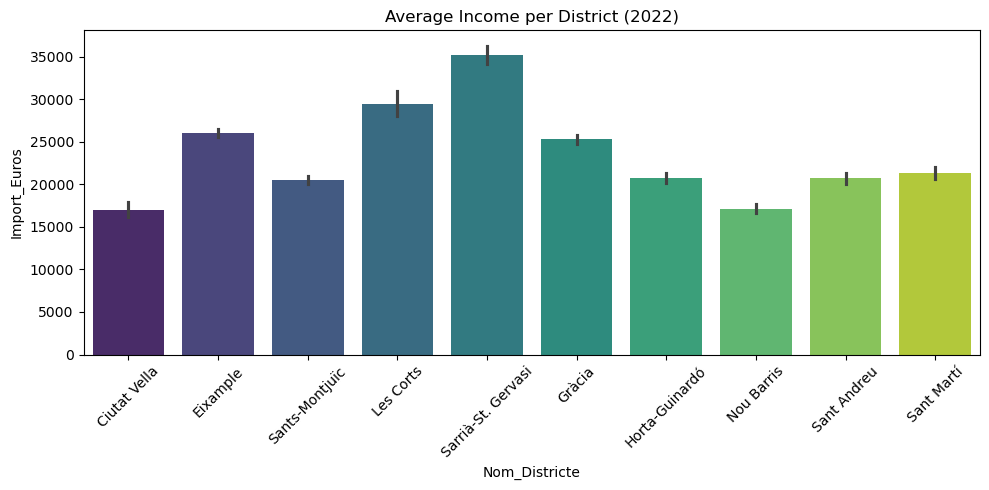

In [17]:
plt.figure(figsize=(10,5))
sns.barplot(data=df_socio, x="Nom_Districte", y="Import_Euros", palette="viridis")
plt.title("Average Income per District (2022)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Consumption distribution

This can help us understand consumption trends.

In [ ]:
df_consum = pd.read_parquet("clean/consum_clean.parquet")

plt.figure(figsize=(8,4))
sns.histplot(df_consum['consumption_l_day'], bins=50, kde=True)
plt.title("Distribution of Daily Water Consumption")
plt.xlabel("Liters per Day")
plt.show()

It is extremly concentrated near 0, so we should plot it in logarithmic scale. We plot it by use type to have a better overview of the consumption trends. 

In [ ]:
sns.boxplot(data=df_consum, x='use_type', y='consumption_l_day')
plt.yscale('log')  # Log scale to make differences visible
plt.title("Consumption by Use Type (Log Scale)")
plt.show()


### Distribution of leaks per month 

This can help us see if there are some time periods where there are more leaks or less. 

In [ ]:
df_fuites = pd.read_parquet("clean/fuites_clean.parquet")
df_fuites['timestamp'] = pd.to_datetime(df_fuites['timestamp'])
df_fuites['month'] = df_fuites['timestamp'].dt.to_period('M')

leaks_per_month = df_fuites.groupby('month').size().reset_index(name='num_leaks')
leaks_per_month['month'] = leaks_per_month['month'].astype(str)  

plt.figure(figsize=(10,4))
sns.lineplot(data=leaks_per_month, x='month', y='num_leaks', marker='o')
plt.title("Number of Leaks per Month")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### Distribution of meteo data

- Temperature variation from 2022-2024.
- Monthly rainfall distribution per month (2022-2024)

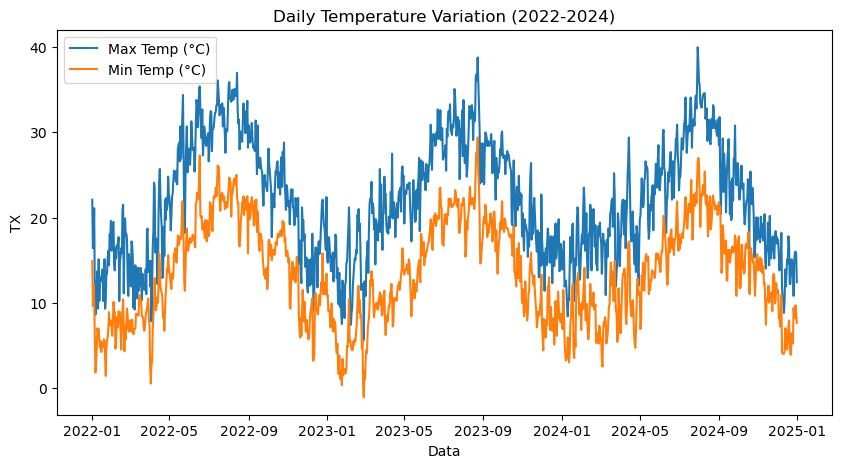

/var/folders/gy/5nns71_n7nx_v_2mkns5_k340000gn/T/ipykernel_53278/4065786337.py:9: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df_meteo, x='month', y='PPT', estimator=sum, ci=None)


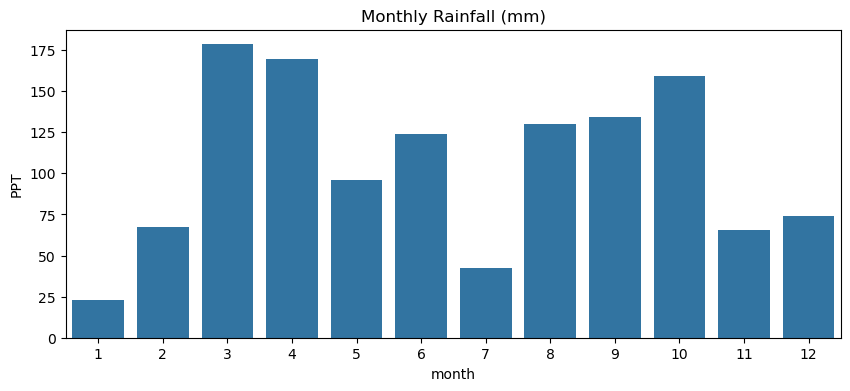

In [21]:
fig, ax1 = plt.subplots(figsize=(10,5))
sns.lineplot(data=df_meteo, x='Data', y='TX', label='Max Temp (°C)', ax=ax1)
sns.lineplot(data=df_meteo, x='Data', y='TN', label='Min Temp (°C)', ax=ax1)
ax1.set_title("Daily Temperature Variation (2022-2024)")
plt.legend()
plt.show()

plt.figure(figsize=(10,4))
sns.barplot(data=df_meteo, x='month', y='PPT', estimator=sum, ci=None)
plt.title("Monthly Rainfall (mm)")
plt.show()
